In [1]:
#
# 2017-08-31
#
# XGB - решение - дурняк, но работает
#
#
#

In [2]:
import sys, os, math
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
def dataClean( df ) :
    def cn (cc) : 
        cc = np.reshape(cc.values,(len(df)))
        return([jj for jj,dd in enumerate(cc.tolist()) if dd ])
    ##df=df.fillna(0.0)
    badly = np.zeros((len(df)),dtype=np.int32)
    ##cols  = df.columns.tolist()
    ##print(cols)
    for ii,nn in enumerate(df.columns.tolist()) :
        
        if (ii==0) and (nn.startswith('Chloro')) : # Chlorophyl
            cc = ((df[[ii]]<0.0) | (df[[ii]]>1.0))
            df.iloc[cn(cc),ii] = 0.0
            #badly[cn(cc)] += 1
        
        if (ii==1) and (nn.startswith('Depth')) : 
            cc = (df[[ii]]> 0.0);      df.iloc[cn(cc),ii] = -df.iloc[cn(cc),ii]
            cc = (df[[ii]]< -10000.0); df.iloc[cn(cc),ii] = -10000.0
            badly[cn(cc)] += 1
        
        if (ii==3) and (nn.startswith('Eastward')) :
            cc = (df[[ii]]< 0.0);      df.iloc[cn(cc),ii] = 0.0
            cc = (df[[ii]]> 5.0);      df.iloc[cn(cc),ii] = 5.0
            badly[cn(cc)] += 1
        
        if (ii==4) and (nn.startswith('Latitude')) :
            cc = (df[[ii]]< -90.0);      df.iloc[cn(cc),ii] = -90.0; badly[cn(cc)] += 1
            cc = (df[[ii]]>  90.0);      df.iloc[cn(cc),ii] =  90.0; badly[cn(cc)] += 1
        
        if (ii==5) and (nn.startswith('Longitude')) :
            cc = (df[[ii]]< -180.0);      df.iloc[cn(cc),ii] = -180.0; badly[cn(cc)] += 1
            cc = (df[[ii]]>  180.0);      df.iloc[cn(cc),ii] =  180.0; badly[cn(cc)] += 1
        
        if (ii==6) and (nn.startswith('Northward')) :
            cc = (df[[ii]]< 0.0);      df.iloc[cn(cc),ii] = 0.0
            cc = (df[[ii]]> 5.0);      df.iloc[cn(cc),ii] = 5.0
            badly[cn(cc)] += 1
        
        if (ii==7) and (nn.startswith('Oceanic')) : 
            cc = (df[[ii]]> 0.0);      df.iloc[cn(cc),ii] = -df.iloc[cn(cc),ii]
            cc = (df[[ii]]< -10000.0); df.iloc[cn(cc),ii] = -10000.0
            badly[cn(cc)] += 1
        
        if (ii==8) and (nn.startswith('SOG')) : 
            cc = (df[[ii]]<  0.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
            cc = (df[[ii]]> 35.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
        
        if (ii==9) and (nn.startswith('Salinity')) : 
            cc = (df[[ii]]<  0.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
            #cc = (df[[ii]]> 35.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
        
        if (ii==10) and (nn.startswith('Sea')) : 
            cc = (df[[ii]]<  0.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
            #cc = (df[[ii]]> 35.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
        
        if (ii==11) and (nn.startswith('Speed')) : 
            cc = (df[[ii]]<  0.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
            cc = (df[[ii]]> 35.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1

        if (ii==11) and (nn.startswith('Thermocline')) : 
            cc = (df[[ii]]<     0.0);      df.iloc[cn(cc),ii] =     0.0; badly[cn(cc)] += 1
            cc = (df[[ii]]>  5000.0);      df.iloc[cn(cc),ii] =  5000.0; badly[cn(cc)] += 1

        if (ii==15) and (nn.startswith('Water')) : 
            cc = (df[[ii]]<  -100.0);      df.iloc[cn(cc),ii] =     0.0; badly[cn(cc)] += 1
            #cc = (df[[ii]]>  5000.0);      df.iloc[cn(cc),ii] =  5000.0; badly[cn(cc)] += 1

    print(cc.sum(),badly.sum())
    return(badly)

In [4]:
# Читаем train список
train_list = pd.read_csv('../Data/training.txt', header=None)
train_list.columns=['trackfile','typing']

In [5]:
train_list.head()

,trackfile,typing
0,100047,trawler
1,100070,longliner
2,100080,seiner
3,100093,other
4,100144,trawler


In [6]:
y_class = train_list['typing'].unique().tolist(); y_class

['trawler', 'longliner', 'seiner', 'other', 'support']

In [7]:
# Читаем test список
test_list = pd.read_csv('../Data/testing.txt', header=None)
test_list.columns=['trackfile']
print 'test length:',len(test_list)
test_list.head()

test length: 1211


,trackfile
0,100015
1,100045
2,100060
3,100112
4,100131


In [12]:
# Строим train массивы из файлов списка
y_train = []

for ii,ffile in enumerate((train_list['trackfile'].values.tolist())) : #[:10]) :
    xx = pd.read_csv(os.path.join('../Data/VesselTracks',str(ffile)+'.csv'))
    xx['Time']  = xx[[1]]
    xx['sTime'] = np.abs(xx.Time.diff(-1)).fillna(0.0)
    xx['hTime'] = xx.sTime/3600.0
    xx['Depth'] = xx[[5]]
    
    havLa       = (0.5*(1.0-np.cos(-xx.Latitude.diff(-1)/180.0*math.pi))).fillna(0.0)
    havLo       = (0.5*(1.0-np.cos(-xx.Longitude.diff(-1)/180.0*math.pi))).fillna(0.0)
    
    cosLa       = (np.cos(xx.Latitude/180.0*math.pi)).fillna(0.0)
    
    hav         = (havLa+cosLa*cosLa.shift(-1)*havLo).fillna(0.0)
    dist = (2*6371.0*np.arcsin(np.sqrt(hav))).fillna(0.0)
    
    xx['Distance'] = dist
    xx['Speed']    = (dist/1.852/xx.hTime).fillna(0.0)
    
    xx = xx.fillna(0.0)
    
    if (ii==0) : trainAll = xx.copy()
    else : trainAll = trainAll.append(xx.copy())
        
    y1          = [0]*len(y_class);  
    y1[y_class.index(train_list.typing[ii])] = 1;
    y_train.append(y1)
    
y_train = np.array(y_train)
print(y_train.shape,trainAll.shape)

((1209, 5), (8080623, 20))


In [14]:
trainAll.to_csv('../Data/trainingAll.csv',index=False)

In [26]:
trainAll = pd.read_csv('../Data/trainingAll.csv')

In [27]:
trainWeights = dataClean(trainAll)

(Speed    27178
dtype: int64, 2661055)


In [17]:
!ls -la ../Data
trainAll.shape

total 2118448
drwxrwxrwx 1 boba boba       4096 сен  1 15:28 .
drwxrwxrwx 1 boba boba       4096 сен  1 16:12 ..
-rwxrwxrwx 1 boba boba  973453918 сен  1 15:29 testingAll.csv
-rwxrwxrwx 1 boba boba       8477 авг 25 23:42 testing.txt
-rwxrwxrwx 1 boba boba 1195264916 сен  2 01:53 trainingAll.csv
-rwxrwxrwx 1 boba boba      18151 авг 25 23:40 training.txt
drwxrwxrwx 1 boba boba     528384 авг 26 00:37 VesselTracks


(8080623, 20)

In [18]:
##train_list.head()
trainIndex=train_list.copy()
##trainIndex.head()
trainIndex['y'] = -1
for ii in range(len(trainIndex)) : 
    trainIndex.y[ii] = y_class.index(trainIndex.typing[ii])
    
trainIndex=trainIndex.set_index('trackfile')
trainIndex.head()

/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,typing,y
trackfile,,
100047,trawler,0
100070,longliner,1
100080,seiner,2
100093,other,3
100144,trawler,0


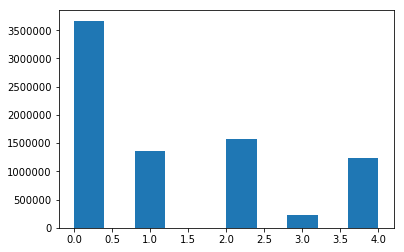

,TrackNumber,Chlorophyll Concentration,Depth,Distance,Eastward Water Velocity,Latitude,Longitude,Northward Water Velocity,Oceanic Depth,SOG,...,Sea Temperature,Speed,Thermocline Depth,Time,Time(seconds),Water Surface Elevation,hTime,oceanic depth,sTime,y
0,100047,0.3105,-4.0,3.186329,0.06,41.101078,1.235355,0.01,NaN,7.4,...,10.7,6.652769,111.0,0,0,-0.22,0.258611,-4.0,931.0,0
1,100047,0.3043,-11.0,5.981159,0.06,41.074507,1.221120,0.02,NaN,5.1,...,10.7,9.012747,109.5,931,931,-0.22,0.358333,-11.0,1290.0,0
2,100047,0.3059,-16.0,8.779740,0.06,41.043652,1.279553,0.04,NaN,10.2,...,10.7,10.337037,117.4,2221,2221,-0.23,0.458611,-16.0,1651.0,0
3,100047,0.3674,-46.0,0.000000,0.08,40.998603,1.365502,0.07,NaN,10.5,...,10.6,0.000000,123.8,3872,3872,-0.24,0.000278,-46.0,1.0,0
4,100047,0.3674,-46.0,0.000095,0.08,40.998603,1.365502,0.07,NaN,10.5,...,10.6,0.046135,123.8,3873,3873,-0.24,0.001111,-46.0,4.0,0


In [19]:
train = trainAll.set_index('TrackNumber')
train.head()
train['y'] = trainIndex.y
train = train.reset_index()
plt.hist(train.y); plt.show()
train.head()

In [20]:
import xgboost as xgb

/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [21]:
train_x = train.drop(['y','TrackNumber','Time','Time(seconds)'],axis=1)  #[:1000000]
train_y = train.y.values  #[:1000000]

mtrain = xgb.DMatrix(train_x,label=train_y)

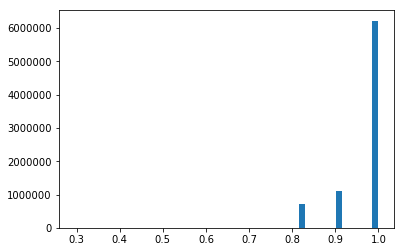

(0.29411764705882354, 1.0, (8080623, 17), 0, 8)

In [37]:
# Добавляем веса, чтобы не удалять записи из массива
temp = (0.0+train_x.shape[1]-1.5*trainWeights)/train_x.shape[1]
mtrain.set_weight(temp)
trainWeights.min(), trainWeights.max()
plt.hist(temp,bins=50); plt.show()
temp.min(),temp.max(), train_x.shape, trainWeights.min(), trainWeights.max()

In [39]:
train_y.shape, train_x.shape, train_x.columns.tolist(), train_y.max()

((8080623,),
 (8080623, 17),
 ['Chlorophyll Concentration',
  'Depth',
  'Distance',
  'Eastward Water Velocity',
  'Latitude',
  'Longitude',
  'Northward Water Velocity',
  'Oceanic Depth',
  'SOG',
  'Salinity',
  'Sea Temperature',
  'Speed',
  'Thermocline Depth',
  'Water Surface Elevation',
  'hTime',
  'oceanic depth',
  'sTime'],
 4)

In [40]:
##import sklearn as sk
##from sklearn.model_selection import cross_val_score

In [41]:
##cross_val_score(estimator=xgb.XGBClassifier(), X=train_x, y=train_y, cv=5, scoring='accuracy')

In [42]:
parms = {'reg':'logistic'}
parms = {'multi':'softmax','num_class':5,'metrics':'mlogloss'}
parms = {'multi':'softmax','num_class':5,'metrics':'mlogloss'}
##parms = {'reg':'logistic'}
##parms = {'reg':'linear','metrics':'auc'}

hist = xgb.cv(parms,mtrain,num_boost_round=30,nfold=5,early_stopping_rounds=4,verbose_eval=True,metrics='mlogloss')
#hist = xgb.train(parms,mtrain,num_boost_round=30,early_stopping_rounds=5)

[0]	train-mlogloss:1.18353+0.000321327	test-mlogloss:1.18357+0.000217645
[1]	train-mlogloss:0.962443+0.000933741	test-mlogloss:0.962493+0.000725745
[2]	train-mlogloss:0.818279+0.00156896	test-mlogloss:0.818388+0.00113038
[3]	train-mlogloss:0.716817+0.00243917	test-mlogloss:0.716918+0.00196464
[4]	train-mlogloss:0.64077+0.00197197	test-mlogloss:0.640891+0.00161875
[5]	train-mlogloss:0.582703+0.00205149	test-mlogloss:0.582834+0.00161775
[6]	train-mlogloss:0.537917+0.00102743	test-mlogloss:0.538055+0.000757014
[7]	train-mlogloss:0.503535+0.00108129	test-mlogloss:0.503687+0.000899338
[8]	train-mlogloss:0.476194+0.0011301	test-mlogloss:0.476368+0.000822161
[9]	train-mlogloss:0.453808+0.00113634	test-mlogloss:0.454+0.00107795
[10]	train-mlogloss:0.435985+0.00131357	test-mlogloss:0.436203+0.00128347
[11]	train-mlogloss:0.41967+0.00115937	test-mlogloss:0.419917+0.00128575
[12]	train-mlogloss:0.405652+0.00197395	test-mlogloss:0.40587+0.00212225
[13]	train-mlogloss:0.394511+0.00188067	test-mlogl

In [43]:
hist

,test-mlogloss-mean,test-mlogloss-std,train-mlogloss-mean,train-mlogloss-std
0,1.183572,0.000218,1.183535,0.000321
1,0.962493,0.000726,0.962443,0.000934
2,0.818388,0.001130,0.818279,0.001569
3,0.716918,0.001965,0.716817,0.002439
4,0.640891,0.001619,0.640770,0.001972
5,0.582834,0.001618,0.582703,0.002051
6,0.538055,0.000757,0.537917,0.001027
7,0.503687,0.000899,0.503535,0.001081
8,0.476368,0.000822,0.476194,0.001130
9,0.454000,0.001078,0.453808,0.001136


In [67]:
xgbmodel = xgb.train(parms,mtrain,num_boost_round=470,verbose_eval=True,xgb_model=xgbmodel) # = 500

In [114]:
##xgbmodel.load_model('../Work/xgbModelClean.bst')
xgbmodel.save_model('../Work/xgbModelClean.bst')

In [68]:
pred_y = xgbmodel.predict(mtrain); ##pred_y[-20:],pred_y.max()

In [69]:
((pred_y==train_y).sum()/float(len(pred_y)))

0.98323594604029907

In [70]:
df_diff = pd.DataFrame(train.TrackNumber,columns=['TrackNumber'])
df_diff['true_y'] = np.array(train_y,dtype=np.uint8)
df_diff['pred_y'] = np.array(pred_y, dtype=np.uint8)

df_diff['OK']    = df_diff.true_y==df_diff.pred_y

#print(df_diff.head())

len(df_diff)-df_diff.OK.sum()
aa = df_diff.groupby(['TrackNumber','OK']).size().reset_index(); aa.columns=['TrackNumber','OK','ccount']; aa.head()
bb = pd.DataFrame(train.TrackNumber.unique(),columns=['TrackNumber'])
bb['xx'] = 1.0; bb=bb.set_index(['TrackNumber'])
cc = aa[['TrackNumber','ccount']][aa.OK==True];  cc.head(); cc = cc.set_index(['TrackNumber']); bb['Yes']=cc
cc = aa[['TrackNumber','ccount']][aa.OK==False]; cc.head(); cc = cc.set_index('TrackNumber'); bb['No'] =cc
bb=bb.reset_index().drop('xx',axis=1).fillna(0)
print(bb.head())
float(len(bb[bb.No>bb.Yes]))/len(bb)*100.0

   TrackNumber      Yes    No
0       100047    669.0   0.0
1       100070    359.0  49.0
2       100080  12162.0   4.0
3       100093   6101.0  22.0
4       100144  15478.0   0.0


0.9098428453267163

In [71]:
trainAll.describe()

,Chlorophyll Concentration,Depth,Distance,Eastward Water Velocity,Latitude,Longitude,Northward Water Velocity,Oceanic Depth,SOG,Salinity,Sea Temperature,Speed,Thermocline Depth,Time,Time(seconds),TrackNumber,Water Surface Elevation,hTime,oceanic depth,sTime
count,8.080623e+06,8.080623e+06,8.080623e+06,8.080623e+06,8.080623e+06,8.080623e+06,8.080623e+06,7.248314e+06,8.080623e+06,8.080623e+06,8.080623e+06,8.080623e+06,8.080623e+06,8.080623e+06,8.080623e+06,8.080623e+06,8.080623e+06,8.080623e+06,832309.000000,8.080623e+06
mean,1.306924e-01,-3.748951e+02,1.316068e+01,1.363955e-01,2.796590e+01,-2.567147e+01,6.817065e-02,-3.830014e+02,3.911368e+00,3.137154e+01,1.257363e+01,3.307977e+00,-8.999723e+03,3.791576e+06,3.791576e+06,1.163657e+05,-9.052766e+03,3.014258e-01,-300.709360,1.085133e+03
std,2.037974e-01,6.178872e+02,3.558859e+02,1.941308e-01,2.914675e+01,1.090697e+02,1.105915e-01,6.315409e+02,4.690608e+00,9.921257e+00,1.151546e+01,4.720997e+00,2.888963e+04,2.274637e+06,2.274637e+06,9.198222e+03,2.869292e+04,5.182724e+00,479.412829,1.865781e+04
min,0.000000e+00,-1.000000e+04,0.000000e+00,0.000000e+00,-9.000000e+01,-1.800000e+02,0.000000e+00,-1.000000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.999900e+04,0.000000e+00,0.000000e+00,1.000470e+05,-9.999900e+04,0.000000e+00,-2241.000000,0.000000e+00
25%,0.000000e+00,-8.850000e+02,1.517171e-03,0.000000e+00,1.987981e+00,-1.246882e+02,0.000000e+00,-9.080000e+02,0.000000e+00,3.400000e+01,6.000000e-01,6.680306e-03,8.470000e+01,1.798463e+06,1.798463e+06,1.085250e+05,-1.500000e+00,3.888889e-03,-389.000000,1.400000e+01
50%,0.000000e+00,-3.400000e+01,1.109556e-02,4.000000e-02,4.103076e+01,-5.097478e+00,0.000000e+00,-3.500000e+01,1.600000e+00,3.420000e+01,9.000000e+00,2.691390e-01,1.326000e+02,3.729598e+06,3.729598e+06,1.159690e+05,-2.300000e-01,6.666667e-02,-23.000000,2.400000e+02
75%,1.744000e-01,-3.000000e+00,3.386869e-01,2.200000e-01,5.362523e+01,1.537687e+01,1.100000e-01,-4.000000e+00,7.800000e+00,3.480000e+01,2.650000e+01,5.947320e+00,1.799000e+02,5.718402e+06,5.718402e+06,1.246320e+05,2.700000e-01,2.511111e-01,-2.000000,9.040000e+02
max,1.000000e+00,0.000000e+00,1.947627e+04,2.460000e+00,9.000000e+01,1.800000e+02,2.090000e+00,0.000000e+00,3.460000e+01,4.020000e+01,3.480000e+01,3.499928e+01,2.551600e+03,7.948768e+06,7.948768e+06,1.327590e+05,1.870000e+00,1.726042e+03,719.000000,6.213751e+06


In [72]:
testAll.describe()

,Chlorophyll Concentration,Depth,Distance,Eastward Water Velocity,Latitude,Longitude,Northward Water Velocity,Oceanic Depth,SOG,Salinity,Sea Temperature,Speed,Thermocline Depth,Time,Time(seconds),TrackNumber,Water Surface Elevation,hTime,oceanic depth,sTime
count,6.586899e+06,6.586899e+06,6.586899e+06,6.586899e+06,6.586899e+06,6.586899e+06,6.586899e+06,5.780701e+06,6.586899e+06,6.586899e+06,6.586899e+06,6.586899e+06,6.586899e+06,6.586899e+06,6.586899e+06,6.586899e+06,6.586899e+06,6.586899e+06,806198.000000,6.586899e+06
mean,1.836288e-01,-4.125636e+02,6.853781e+00,1.438525e-01,2.692668e+01,4.557332e+00,7.746507e-02,-4.221097e+02,3.923371e+00,3.091068e+01,1.185751e+01,3.338380e+00,-1.041067e+04,3.789619e+06,3.789619e+06,1.164658e+05,-1.041934e+04,3.705482e-01,-341.318816,1.333973e+03
std,2.376818e-01,8.057506e+02,2.033259e+02,1.874133e-01,3.033503e+01,8.531220e+01,1.191309e-01,8.397425e+02,4.505223e+00,1.056854e+01,1.198546e+01,4.530877e+00,3.077808e+04,2.288671e+06,2.288671e+06,9.561745e+03,3.055021e+04,6.095759e+00,494.724329,2.194473e+04
min,0.000000e+00,-1.000000e+04,0.000000e+00,0.000000e+00,-9.000000e+01,-1.800000e+02,0.000000e+00,-1.000000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.999900e+04,0.000000e+00,0.000000e+00,1.000150e+05,-9.999900e+04,0.000000e+00,-2228.000000,0.000000e+00
25%,0.000000e+00,-9.070000e+02,1.828281e-03,0.000000e+00,1.061401e+00,-9.760993e+00,0.000000e+00,-9.200000e+02,0.000000e+00,3.390000e+01,0.000000e+00,7.803044e-03,8.350000e+01,1.786442e+06,1.786442e+06,1.080470e+05,-1.700000e+00,5.555556e-03,-789.000000,2.000000e+01
50%,9.660000e-02,-2.700000e+01,2.327186e-02,7.000000e-02,3.899289e+01,1.107060e+00,0.000000e+00,-2.800000e+01,2.300000e+00,3.420000e+01,9.600000e+00,7.579832e-01,1.435000e+02,3.696384e+06,3.696384e+06,1.170240e+05,-4.000000e-01,8.722222e-02,-23.000000,3.140000e+02
75%,2.674000e-01,-3.000000e+00,6.219797e-01,2.400000e-01,5.223359e+01,1.612305e+01,1.300000e-01,-3.000000e+00,7.500000e+00,3.480000e+01,2.600000e+01,5.885579e+00,1.841000e+02,5.739774e+06,5.739774e+06,1.245090e+05,2.000000e-01,2.555556e-01,-2.000000,9.200000e+02
max,1.000000e+00,0.000000e+00,1.832449e+04,2.110000e+00,9.000000e+01,1.800000e+02,1.490000e+00,0.000000e+00,3.480000e+01,4.040000e+01,3.470000e+01,3.499575e+01,2.614500e+03,7.948752e+06,7.948752e+06,1.326810e+05,3.140000e+00,1.762986e+03,850.000000,6.346749e+06


In [73]:
##xgbmodel.save_model('../Work/xgbModel.bst')

In [75]:
fimp  = xgbmodel.get_fscore();
ffimp = [[k,fimp[k]] for k in fimp.keys()]; 
ffimp.sort(key=lambda x: x[1],reverse=True)
tempsum = 0
for temp in ffimp : tempsum+=temp[1];
##print(tempsum)
for ii,temp in enumerate(ffimp) : 
    ffimp[ii][1] = float(ffimp[ii][1])/tempsum*100.0;
ffimp

[['Longitude', 12.745367192862044],
 ['Latitude', 12.156485929993137],
 ['SOG', 9.46808510638298],
 ['Oceanic Depth', 7.943033630748113],
 ['Water Surface Elevation', 7.567604667124228],
 ['Sea Temperature', 7.234042553191489],
 ['Thermocline Depth', 6.858613589567604],
 ['Chlorophyll Concentration', 6.004804392587508],
 ['Salinity', 5.514756348661633],
 ['Eastward Water Velocity', 5.410432395332876],
 ['Depth', 4.9258750857927245],
 ['Northward Water Velocity', 4.85175017158545],
 ['Speed', 2.6918325326012353],
 ['Distance', 2.6664378860672615],
 ['hTime', 2.355525051475635],
 ['oceanic depth', 1.6053534660260809]]

In [76]:
y_class, trainIndex['typing'][132759]

(['trawler', 'longliner', 'seiner', 'other', 'support'], 'seiner')

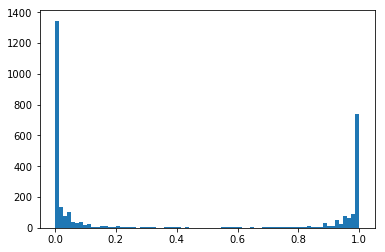

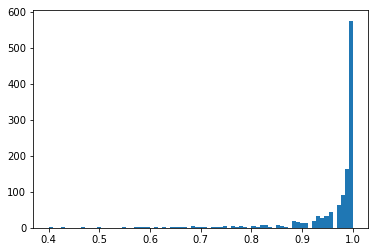

15

In [77]:
ppred = pd.DataFrame()
ppred['TrackNumber'] = train.TrackNumber
ppred['pred_y'] = pred_y
ppred['true_y'] = train.y


g0pred = ppred.groupby(['TrackNumber','pred_y']).agg(['count'])
g1pred = ppred.groupby(['TrackNumber']).agg(['count']); g1pred
g0pred['pr'] = np.round(g0pred.true_y/g1pred.true_y,2)
g2pred = g0pred.reset_index()
g2pred = g2pred.pr.groupby(g2pred.TrackNumber).max()
plt.hist(g0pred.pr,bins=75); plt.show()
plt.hist(g2pred,bins=75); plt.show()
#g0pred
g2pred.head()
len(g2pred[g2pred<0.60])

In [78]:
# Готовим решение по test

In [54]:
for ii,ffile in enumerate((test_list['trackfile'].values.tolist())): # [:10]) :
    xx = pd.read_csv(os.path.join('../Data/VesselTracks',str(ffile)+'.csv'))
    xx['Time']  = xx[[1]]
    xx['sTime'] = np.abs(xx.Time.diff(-1)).fillna(0.0)
    xx['hTime'] = xx.sTime/3600.0
    xx['Depth'] = xx[[5]]
    
    havLa       = (0.5*(1.0-np.cos(-xx.Latitude.diff(-1)/180.0*math.pi))).fillna(0.0)
    havLo       = (0.5*(1.0-np.cos(-xx.Longitude.diff(-1)/180.0*math.pi))).fillna(0.0)
    
    cosLa       = (np.cos(xx.Latitude/180.0*math.pi)).fillna(0.0)
    
    hav         = (havLa+cosLa*cosLa.shift(-1)*havLo).fillna(0.0)
    dist = (2*6371.0*np.arcsin(np.sqrt(hav))).fillna(0.0)
    
    xx['Distance'] = dist
    xx['Speed']    = (dist/1.852/xx.hTime).fillna(0.0)
    
    xx = xx.fillna(0.0)
    
    if (ii==0) : testAll = xx.copy()
    else : testAll = testAll.append(xx.copy())
        
print(testAll.shape)

(6586899, 20)


In [55]:
#testAll.to_csv('../Data/testingAll.csv',index=False)

In [56]:
#testAll = pd.read_csv('../Data/testingAll.csv')

In [57]:
#testWeights = dataClean(testAll)

(Speed    22447
dtype: int64, 2845209)


In [79]:
!ls -la ../Result
!ls -la ../Data
testAll.shape

total 33
drwxrwxrwx 1 boba boba  4096 сен  1 21:36 .
drwxrwxrwx 1 boba boba  4096 сен  1 16:12 ..
drwxrwxrwx 1 boba boba     0 сен  1 21:36 Best
-rwxrwxrwx 1 boba boba 23057 сен  1 21:19 bobaFish.csv
-rwxrwxrwx 1 boba boba   413 сен  1 16:53 FishingForFishermen2.java
drwxrwxrwx 1 boba boba     0 сен  1 16:36 .ipynb_checkpoints
total 2118448
drwxrwxrwx 1 boba boba       4096 сен  1 15:28 .
drwxrwxrwx 1 boba boba       4096 сен  1 16:12 ..
-rwxrwxrwx 1 boba boba  973453918 сен  2 02:54 testingAll.csv
-rwxrwxrwx 1 boba boba       8477 авг 25 23:42 testing.txt
-rwxrwxrwx 1 boba boba 1195264916 сен  2 01:53 trainingAll.csv
-rwxrwxrwx 1 boba boba      18151 авг 25 23:40 training.txt
drwxrwxrwx 1 boba boba     528384 авг 26 00:37 VesselTracks


(6586899, 20)

In [80]:
test_x = testAll.drop(['TrackNumber','Time','Time(seconds)'],axis=1)  #[:1000000]
mtest  = xgb.DMatrix(test_x)
test_x.shape

(6586899, 17)

In [81]:
test_y = xgbmodel.predict(mtest); ##pred_y[-20:],pred_y.max()

   TrackNumber  pred_y
0       100015       2
1       100015       1
2       100015       1
3       100015       1
4       100015       1
('Common result \n',    TrackNumber  pred_y      pr
0       100015       0  0.0376
1       100015       1  0.8243
2       100015       2  0.1368
3       100015       3  0.0013
4       100045       0  1.0000)
Only result pred = 1.0 
   TrackNumber  pred_y   pr
0       100015       1  1.0
1       100045       0  1.0
2       100060       1  1.0
3       100112       0  1.0
4       100131       0  1.0
                        sTime     sTimeX     ssTime       prS       prX  \
TrackNumber pred_y                                                        
100015      0       1151293.0   803030.0   977161.5  0.145367  0.101394   
            1       5987506.0  6633133.0  6310319.5  0.756008  0.837527   
            2        670021.0   410381.0   540201.0  0.084600  0.051816   
            3        111079.0    73355.0    92217.0  0.014025  0.009262   
100045      

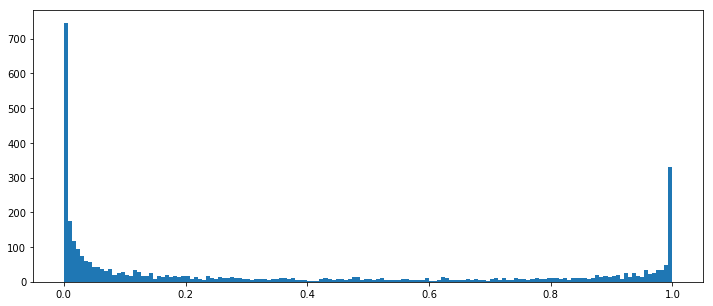

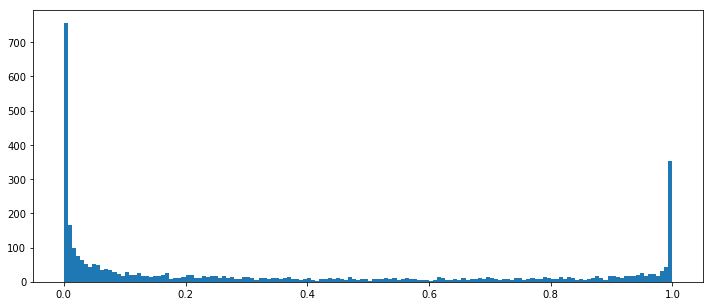

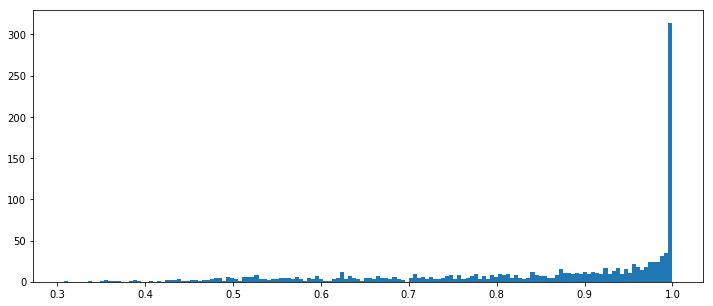

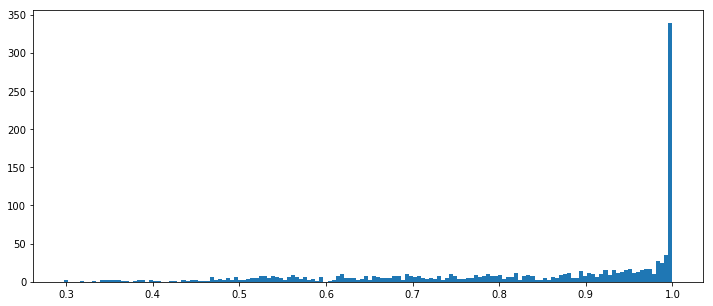

170 0.0 1.0 0.0 1.0 1e-06 1.0


In [110]:
# Распределение результата test
ppred = pd.DataFrame()
ppred['TrackNumber'] = testAll.TrackNumber
ppred['pred_y'] = np.array(test_y,dtype=np.uint8)
print(ppred.head())

tySize = ppred.groupby(['TrackNumber','pred_y']).size();
tSize  = ppred.groupby(['TrackNumber']).size();

g0pred = pd.DataFrame(np.round(tySize/tSize,4)).reset_index()   # common result table [Track#, pred#, prob]
g0pred.columns=['TrackNumber','pred_y','pr']

print('Common result \n',g0pred.head())

ggmax, g4pred = [], g0pred.groupby('TrackNumber')

for tt in g0pred.TrackNumber.unique().tolist() :
    aa = g4pred.get_group(tt)
    ggmax.append(aa.pred_y[aa.pr.argmax()])

##print(len(ggmax),ggmax[:40])

g1pred = pd.DataFrame(g0pred.TrackNumber.unique())   # table only one max result for Track# [Track#, pred#, prob]
g1pred['pred_y'] = np.array(ggmax)
g1pred['pr']     = 1.0
g1pred.columns=['TrackNumber','pred_y','pr']

print 'Only result pred = 1.0 \n',g1pred.head()

g2pred = ppred.copy()
g2pred['sTime']  = testAll.sTime
g2pred['sTimeX'] = testAll.sTime.shift()
g2pred = g2pred.fillna(0)

g2pred = g2pred.groupby(['TrackNumber','pred_y']).sum();
g2pred['ssTime'] = (g2pred.sTime+g2pred.sTimeX)*0.5
ttSize = g2pred.reset_index().groupby(['TrackNumber']).sum();
g2pred['prS']  = np.round(g2pred.sTime/ttSize.sTime,6)
g2pred['prX']  = np.round(g2pred.sTimeX/ttSize.sTimeX,6)
g2pred['prSX'] = np.round(g2pred.ssTime/ttSize.ssTime,6)
g2pred['pr']   = g2pred.prSX

print g2pred.head(20)


g3pred = g0pred.pr.groupby(g0pred.TrackNumber).max()            # max pr for each Track#
g3pred = g2pred.reset_index().prSX.groupby(g2pred.reset_index().TrackNumber).max()            # max pr for each Track#

plt.figure(figsize=(12,5)); plt.hist(g0pred.pr,bins=150); plt.show()
plt.figure(figsize=(12,5)); plt.hist(g2pred.prSX,bins=150); plt.show()

g3pred = g0pred.pr.groupby(g0pred.TrackNumber).max()            # max pr for each Track#
plt.figure(figsize=(12,5)); plt.hist(g3pred,bins=150); plt.show()
g3pred = g2pred.reset_index().prSX.groupby(g2pred.reset_index().TrackNumber).max()            # max pr for each Track#
plt.figure(figsize=(12,5)); plt.hist(g3pred,bins=150); plt.show()

print len(g3pred[g3pred<0.60]), g2pred.prS.min(), g2pred.prS.max(), g2pred.prX.min(), g2pred.prX.max(), g2pred.prSX.min(), g2pred.prSX.max()

In [84]:
g0pred.head()
test_r = g0pred.copy()
##print(test_r.pred_y.values.tolist())
test_r['FishingType'] = np.array([y_class[x] for x in test_r.pred_y.values.tolist()])
print(test_r[['TrackNumber','FishingType','pr']].head(15))
test_r[['TrackNumber','FishingType','pr']].to_csv('../Result/bobaFish.csv',index=False,header=False)

    TrackNumber FishingType      pr
0        100015     trawler  0.0376
1        100015   longliner  0.8243
2        100015      seiner  0.1368
3        100015       other  0.0013
4        100045     trawler  1.0000
5        100060     trawler  0.0532
6        100060   longliner  0.7423
7        100060      seiner  0.2039
8        100060     support  0.0005
9        100112     trawler  1.0000
10       100131     trawler  0.8094
11       100131   longliner  0.0029
12       100131       other  0.1877
13       100150   longliner  0.9298
14       100150      seiner  0.0642


In [112]:
#
#  2017-09-02 Взвешенная по времени нахождения около точки (+-) вероятности типов судов
#  2017-09-02 +- хуже 886xxx -> 870xxx
#
g2pred.head()
test_r = g2pred.reset_index().copy()
test_r['pr'] = test_r.prSX
##print(test_r.pred_y.values.tolist())
test_r['FishingType'] = np.array([y_class[x] for x in test_r.pred_y.values.tolist()])
print(test_r[['TrackNumber','FishingType','pr']].head(25))
test_r[['TrackNumber','FishingType','pr']].to_csv('../Result/bobaFish.csv',index=False,header=False)

    TrackNumber FishingType        pr
0        100015     trawler  0.123381
1        100015   longliner  0.796768
2        100015      seiner  0.068208
3        100015       other  0.011644
4        100045     trawler  1.000000
5        100060     trawler  0.111688
6        100060   longliner  0.816666
7        100060      seiner  0.071583
8        100060     support  0.000063
9        100112     trawler  1.000000
10       100131     trawler  0.798129
11       100131   longliner  0.047469
12       100131       other  0.154402
13       100150   longliner  0.917904
14       100150      seiner  0.074431
15       100150     support  0.007665
16       100151     trawler  0.371117
17       100151   longliner  0.012507
18       100151      seiner  0.019218
19       100151     support  0.597159
20       100215     trawler  0.026426
21       100215   longliner  0.025318
22       100215      seiner  0.948256
23       100221     trawler  1.000000
24       100227     trawler  0.999765


In [113]:
#
#  2017-09-02 Взвешенная по времени нахождения около точки (- предыдущее время) вероятности типов судов
#  2017-09-02 - ?????
#
g2pred.head()
test_r = g2pred.reset_index().copy()
test_r['pr'] = test_r.prX
##print(test_r.pred_y.values.tolist())
test_r['FishingType'] = np.array([y_class[x] for x in test_r.pred_y.values.tolist()])
print(test_r[['TrackNumber','FishingType','pr']].head(25))
test_r[['TrackNumber','FishingType','pr']].to_csv('../Result/bobaFish.csv',index=False,header=False)

    TrackNumber FishingType        pr
0        100015     trawler  0.101394
1        100015   longliner  0.837527
2        100015      seiner  0.051816
3        100015       other  0.009262
4        100045     trawler  1.000000
5        100060     trawler  0.092662
6        100060   longliner  0.848095
7        100060      seiner  0.059195
8        100060     support  0.000048
9        100112     trawler  1.000000
10       100131     trawler  0.798759
11       100131   longliner  0.047166
12       100131       other  0.154074
13       100150   longliner  0.917502
14       100150      seiner  0.075145
15       100150     support  0.007353
16       100151     trawler  0.370181
17       100151   longliner  0.014386
18       100151      seiner  0.019686
19       100151     support  0.595747
20       100215     trawler  0.048802
21       100215   longliner  0.002205
22       100215      seiner  0.948993
23       100221     trawler  1.000000
24       100227     trawler  0.999768


In [373]:
#  2017-09-01 Почему-то дает провал на 511650.89 с 890501, хотя не должна?
# Only max predictions pr<-1.0
g1pred.head()
test_r = g1pred.copy()
##print(test_r.pred_y.values.tolist())
test_r['FishingType'] = np.array([y_class[x] for x in test_r.pred_y.values.tolist()])
print(test_r[['TrackNumber','FishingType','pr']].head())
##test_r[['TrackNumber','FishingType','pr']].to_csv('../Result/bobaFish.csv',index=False,header=False)

   TrackNumber FishingType   pr
0       100015   longliner  1.0
1       100045     trawler  1.0
2       100060   longliner  1.0
3       100112     trawler  1.0
4       100131     trawler  1.0
